<a href="https://colab.research.google.com/github/sushmitamuz002/Rossmann_Sales_Prediction_Capstone_Project-ML_Regression-/blob/main/Rossmann_Sales_Prediction_Capstone_Project_(ML_Regression).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [ ]:
# installing required library
%pip install inflection
%pip install Boruta

     |████████████████████████████████| 56 kB 2.2 MB/s 


##**Importing Libraries**

In [ ]:
# importing libary that are required in the porject
import math
import json
import pylab
import pickle
import random
import requests
import datetime
import warnings
import inflection # used when renaming columns in subsection 1.1

import numpy               as np
import pandas              as pd
import xgboost             as xgb
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gs

from scipy                 import stats as ss
from boruta                import BorutaPy
from tabulate              import tabulate

from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

###**0.1 Helper Functions**
Here there are some functions that will be helpful in the project

In [ ]:
# Here there are some functions that will be helpful in the project
# time series cross valdiation fuction that will be used in step 7 to find the best ML model
def cross_validation( x_training, kfold, model_name, model, verbose = False ):
    # creating empty lists to store te error results
    mae_list = []
    mape_list = []
    rmse_list = []
   
    # iterating over a range for the k fold
    for k in reversed (range( 1, kfold+1 ) ):
        if verbose:
            print( f'\nKFold Number: {k}' )
        # getting the start and the end dates for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7 )
        
        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[x_training['date'] >= validation_end_date]
        
        # creating the training and validation datasets
        # training
        xtraining = training.drop( ['date', 'sales'], axis = 1 )
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis = 1 )
        yvalidation = validation['sales']
        
        # setting the model
        m = model.fit( xtraining, ytraining) # it uses the model passed in the function
        
        # prediction
        yhat = m.predict( xvalidation )
        
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ))
        
        # storing performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
       
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


# function to perform a correlation coeficient with categorical variables. it'll be used in section 4: EDA.
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    #correcting cramer's V bias
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

# creating the mean absolute percentage error
def mean_percentage_error( y, y_hat ):
    return np.mean( ( y - y_hat ) / y )

# creating the mean absolute percentage error
def mean_absolute_percentage_error( y, y_hat ):
    return np.mean( np.abs( ( y - y_hat ) / y ) )

# creating a function to calculate the model error
def ml_error( model_name, y, y_hat ):
    mae = mean_absolute_error( y, y_hat )
    mape = mean_absolute_percentage_error( y, y_hat )
    rmse = np.sqrt( mean_squared_error( y, y_hat ) )
    
    
    return pd.DataFrame( { 'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse }, index = [0])

# setting some notebook display as default
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# diplay format(float type)
pd.set_option( 'display.float_format', lambda x: '%.2f' % x )

# setting plot parameters as default
plt.rcParams[ 'figure.figsize' ] = [25, 8]
plt.rcParams[ 'font.size' ] = 24
sns.set_style( "white" )

###**0.2. Loading Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing the dataset
df_Rstore = pd.read_csv("/content/drive/MyDrive/Datasets/Rossmann Stores Data.csv")
df_store = pd.read_csv("/content/drive/MyDrive/Datasets/store.csv")

In [ ]:
# Merging both the dataset on store columnn because it present on both the dataset
df_raw = pd.merge(df_Rstore,df_store , on = 'Store', how='left' )

##**1.0. STEP 1: DATA DESCRIPTION**

In [ ]:
df1 = df_raw.copy()

###**1.1. Rename Columns**
We basically rename them to better manipulate and visualize the data, since the names become shortly and intuitive after renaming

In [ ]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType',
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# creating new names with a snakecase pattern
snakecase = lambda x: inflection.underscore( x )

# creating a list containing the new column names
cols_new = list(map(snakecase, cols_old))

# renaming the dataframe columns
df1.columns = cols_new

###**1.2. Data Dimensions**

In [ ]:
# checking the dimension of data
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


###**1.3. Data Types**

In [ ]:
df1['date'] = pd.to_datetime( df1['date'] ) # changing 'date' column from object to pandas datetime
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

###**1.4. Checking for NANs**

In [ ]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

###**1.5. Filling out NANs**
**competition_distance:**

I'll assume that if the value is missing it's because there'no competitor close to the store. Thus if I input a distance greater than the maximum distance of the column it's the same as there'no competitor close.

The maximum distance is 75,860m. So, if the value is missing, I will input 200,000m

In [ ]:
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

**competition_open_since_month and competition_open_since_year:**

There can be two reasons for missing values in this column:

the store doesn't really have a close competitor.
The store does have a close competitor, but we don't know when it was opened. Maybe the competitor existed before or after the store opening.
So, what I'll do: if the store has a NA in this column, I'll copy the date from this line to the competition_since_month. The main reason to do it is because I believe that this column is important to the model.

For now, it's not a big problem because I'm working in cycles. Thus, if this assumption doesn't help in the modeling performance, I handle it in the next CRISP cycle.

In [ ]:
# competition_open_since_month
df1['competition_open_since_month'].fillna( df1['date'].dt.month, inplace=True )

In [ ]:
# competition_open_since_year
df1['competition_open_since_year'].fillna( df1['date'].dt.year, inplace=True )

####**promo2_since_week and promo2_since_year:**

If there are missing values in these columns, maybe it's because the store is not participating in promo2. So, we'll fill it out with the present date.

In [ ]:
# promo2_since_week
df1['promo2_since_week'].fillna( df1['date'].dt.isocalendar().week, inplace=True )
# promo2_since_year
df1['promo2_since_year'].fillna( df1['date'].dt.year, inplace=True )

####**promo_interval:**

I'm going to create the column is_promo (dummy variable) to indicate whether a store is holding consecutive promo sales on that day and the promo_interval will be dropped in Step 3.

In [ ]:
month_map = {1: 'Jan',  2: 'Feb',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna('', inplace=True) 

# getting month abreviation
df1['month_map'] = df1['date'].dt.strftime( "%b" ) 

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: x['month_map'] in x['promo_interval'].split( ',' ), axis='columns').astype('int')


###**1.6. Change Data Types**
Some features has float as type but they should be integer. So, they're going to be changed.

In [ ]:
# changing the float type to integer type
# competition_open_since_month
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
# competition_open_since_year
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
# promo2_since_year
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
# promo2_since_week
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )

###**1.7. Descriptive Statistics**
This subsection provides both a business notion (with metrics of dispersion and central tendency) and a detection of error in the data

In [ ]:
# dividing data in numerical and categorical
num_attributes = df1.select_dtypes( include = ['int32', 'int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int32', 'int64', 'float64', 'datetime64[ns]'] )

###**1.7.1. Numerical Attributes**

In [ ]:
# Central Tendendy - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skewness, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame(num_attributes.quantile( .25 )).T
d5 = pd.DataFrame(num_attributes.quantile( .75 )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d7 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d8 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T


# concatenating them and printing
m = pd.concat( [d2, d3, d6, d4,  ct2, d5, ct1, d1, d7, d8] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', '25%','median','75%', 'mean', 'std', 'skewness', 'kurtosis'] # renaming columns
m

,attributes,min,max,range,25%,median,75%,mean,std,skewness,kurtosis
0,store,1.00,1115.00,1114.00,280.00,558.00,838.00,558.43,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,2.00,4.00,6.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,3727.00,5744.00,7856.00,5773.82,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,405.00,609.00,837.00,633.15,464.41,1.60,7.09
4,open,0.00,1.00,1.00,1.00,1.00,1.00,0.83,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.00,0.00,1.00,0.38,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.00,0.00,0.00,0.18,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,710.00,2330.00,6910.00,5935.44,12547.65,10.24,147.79
8,competition_open_since_month,1.00,12.00,11.00,4.00,7.00,10.00,6.79,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2008.00,2012.00,2014.00,2010.32,5.52,-7.24,124.07


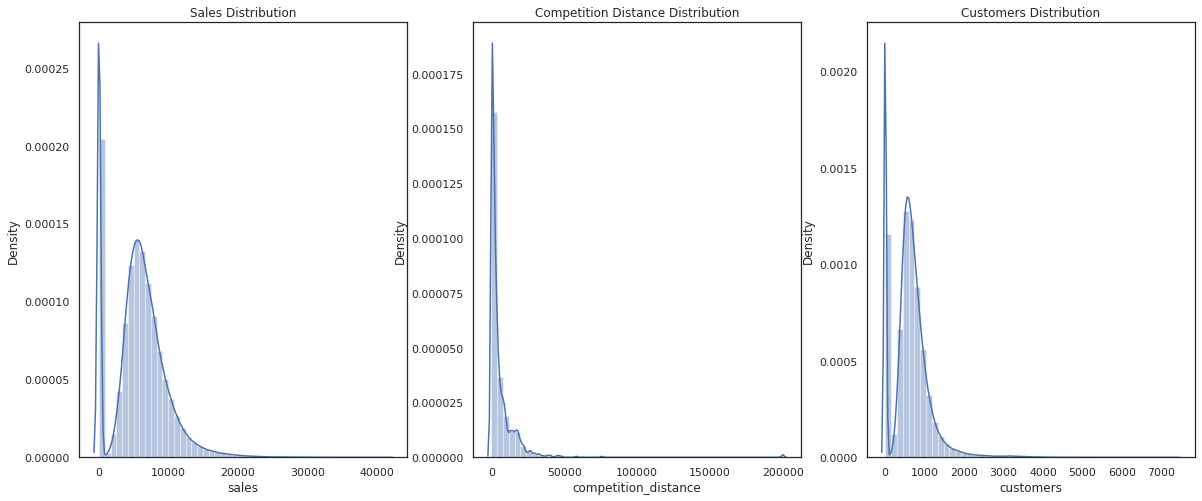

In [ ]:
# plotting distribution plots for finding the central tendency
plt.figure(figsize=(20, 8))

plt.subplot( 1,3,1)
sns.distplot( df1['sales'] )
plt.title( 'Sales Distribution' )

plt.subplot( 1,3,2 )
sns.distplot( df1['competition_distance'] )
plt.title( 'Competition Distance Distribution' );

plt.subplot( 1,3,3 )
sns.distplot( df1['customers'] )
plt.title( 'Customers Distribution' );

In EDA Section I'll check if sales distribution is or not normal.

###**1.7.2. Categorical Attributes**

In [ ]:
# taking a first look at the levels of each categorical variables
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

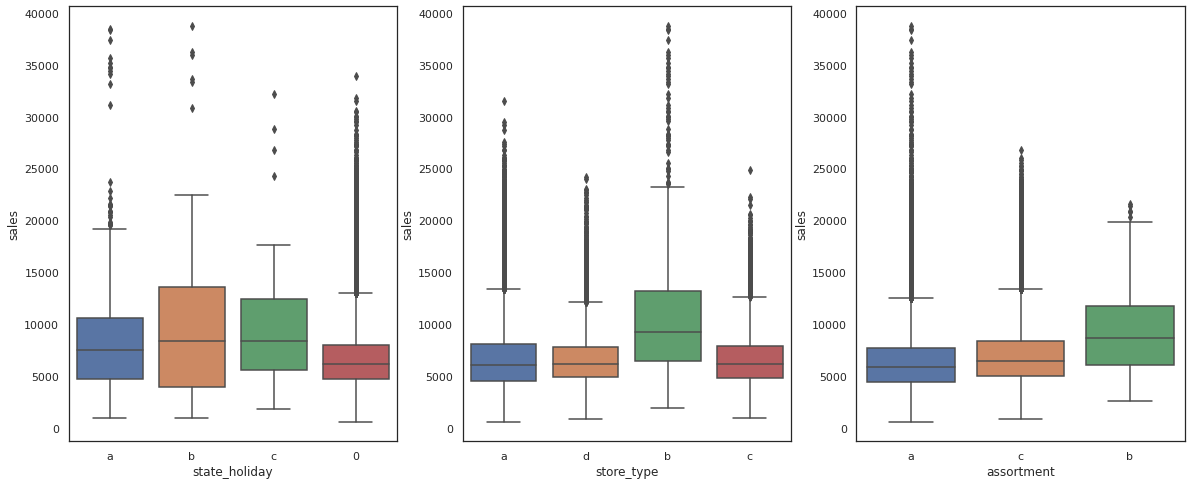

In [ ]:
# plotting box plot for categorical variables
plt.figure(figsize=(20,8))
aux = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )]

plt.subplot( 1, 3, 1 )
sns.boxplot( x = 'state_holiday', y ='sales', data = aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x = 'store_type', y ='sales', data = aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x = 'assortment', y = 'sales', data = aux );

##**2.0. STEP 2: FEATURE ENGINEERING**

In [ ]:
df2 = df1.copy()

####**2.1. Hypothesis Mind Map**
To better understand the relationship between the target variable (sales) and the features, I'll create some hypothesis based on the business problem to guide the feature engineering and then the exploratory data analysis.

In the EDA section, I'll validate these hypothesis and it'll let me have a good notion about the relation between the features and the target and it will help me to choose more accurately what feature to use when modeling.

However, before I do that, a mind map can be useful when creating all the hypothesis.

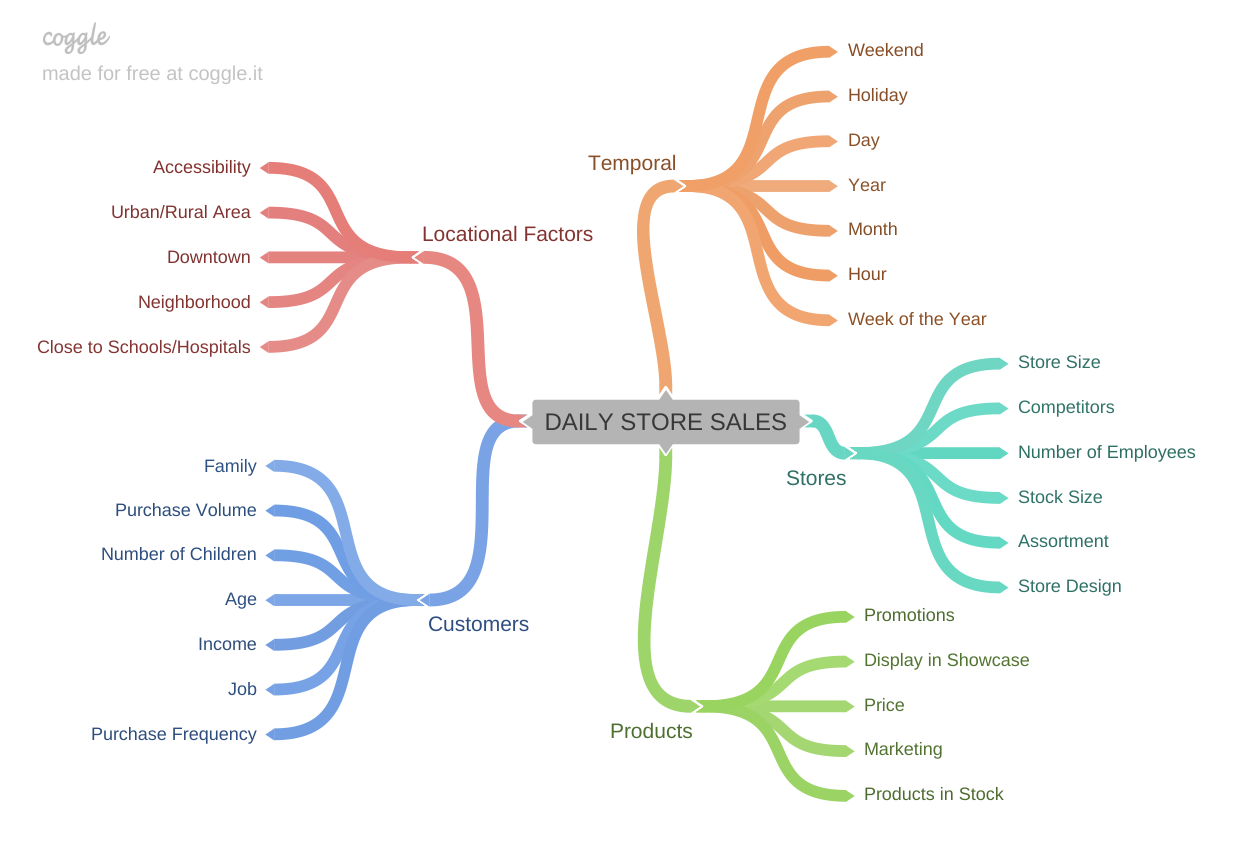

###**2.2. Hypothesis Creation**
####**2.1.1. Store Hypothesis**
1. Stores with more employees should sell more.

2. Stores with greater stock capacity should sell more.

3. Larger stores should sell more.

4. Stores with a larger assortment should sell more.

5. Stores with closer competitors should sell less.

6. Stores with longer competitors should sell more

####**2.1.1. Product Hypothesis**
1. Stores that invest more in Marketing should sell more.

2. Stores with greater product exposure should sell more.

3. Stores with lower priced products should sell more.

5. Stores with more aggressive promotions (bigger discounts) should sell more.

6. Stores with active promotions for longer should sell more.

7. Stores with more promotion days should sell more.

8. Stores with more consecutive promotions should sell more.

####**2.1.1. Temporal Hypothesis**
1. Stores open during the Christmas holiday should sell more.

2. Stores should be selling more over the years.

3. Stores should sell more in the second half of the year.

4. Stores should sell more after the 10th of each month.

5. Stores should sell less on weekends.

6. Stores should sell less during school holidays.

####**2.3. Hypothesis Final List**
The next step is to choose which of them will be considered in the EDA section. The criterion I'll use is the availability of the corresponding feature. For instance, there's no data for number of employees or stock size, so, their corresponding hypothesis will not be considered.

This, the following hypothesis final list is created.

1. Stores with a larger assortment should sell more.

2. Stores with closer competitors should sell less.

3. Stores with longer competitors should sell more

4. Stores with active promotions for longer should sell more.

5. Stores with more promotion days should sell more.

6. Stores with more consecutive promotions should sell more.

7. Stores open during the Christmas holiday should sell more.

8. Stores should be selling more over the years.

9. Stores should sell more in the second half of the year.

10. Stores should sell more after the 10th of each month.

11. Stores should sell less on weekends.

12. Stores should sell less during school holidays.

###**2.4. Feature Engineering**
Now it's time to create some new features. It'll basically follow the needs of the list of hypothesis.

Year, month, day, week of year and year week

In [ ]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
df2['week_of_year'] = df2['week_of_year'].astype( int )

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

####**competition since and promo since**

There are two columns related to competition. I'll make them only one date and then subract from the sale's date. It's the basically the same for promo since

In [ ]:
# competition_since: how long the competition exists considering the purchase date
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis = 1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int ) # to get month

In [ ]:
# promo_since: how long is there an active promotion
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days = 7 ) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )

assortment and state holiday

In [ ]:
#assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular')

Since store type has no description in the data source, I wont change it.

##**3.0. STEP 3: FILTERING VARIABLES**

In [ ]:
df3 = df2.copy()

Based on business restrictions (e.g. we won't have a variable avaliable in the future to use in the prediciton), we have to properly filter variables.

###**3.1. Row Filtering**
open: it's kind of obvious that closed stores has no sales in that day. Thus, this column also won't be used.

In [ ]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

###**3.2. Columns Selection**
customers: I can't use customers because I won't have this data for the next six weeks (the prediction period) unless I build another project to predict how many customers the stores will have in that period. Since this is not the case, I'll drop it.

promo_interval and month_map were used to create new columns. They'll not be used anymore.

In [ ]:
# dropping the columns
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop( cols_drop, axis = 1 )